C:\Users\rishe\AppData\Local\Temp\ipykernel_40600\2364327113.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=start, end=end, freq='M')
c:\Users\rishe\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


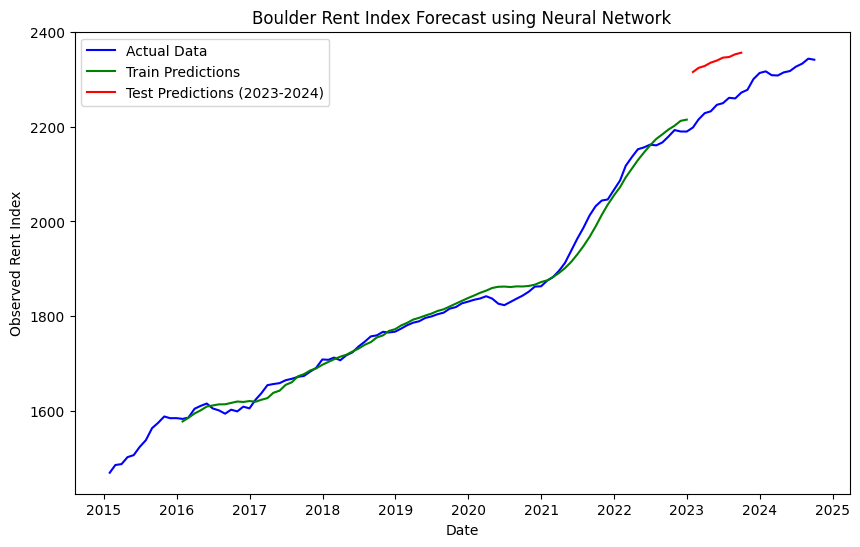

Training Accuracy: MAE=12.732643897518873, RMSE=16.48526182208965, MAPE=0.6843909991928375
Testing Accuracy (2023-2024): MAE=15.192997111870682, RMSE=16.402309500596523, MAPE=0.654278845489527


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def preprocess_data(file_path='datasets/observed_rent_index_co.pkl', region='Boulder', start='2015-01-31', end='2024-09-30'):
    # Read the pickle file
    df = pd.read_pickle(file_path)
    
    # Filter data for the specific region
    region_data = df[df['RegionName'] == region]['observed_rent_index'].values[0]
    
    # Create date range from start to end
    date_range = pd.date_range(start=start, end=end, freq='M')
    
    # Create a DataFrame with dates and rent values
    df_region = pd.DataFrame({
        'ds': date_range,
        'y': region_data
    })
    
    return df_region

def create_sequences(data, look_back=12):
    """Convert time series data into supervised learning problem (X, y)."""
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

def build_nn_model(input_shape):
    """Build and compile a neural network model."""
    model = Sequential()
    model.add(Dense(128, input_dim=input_shape, activation='relu'))  # First hidden layer
    model.add(Dense(64, activation='relu'))  # Second hidden layer
    model.add(Dense(32, activation='relu'))  # Second hidden layer
      # Output layer
    model.add(Dense(1))  # Output layer
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_nn_model(file_path='datasets/observed_rent_index_co.pkl', region='Boulder'):
    # Preprocess data
    df_region = preprocess_data(file_path, region)
    
    # Split data into training (2015-2022) and testing (2023-2024) periods
    train_data = df_region[df_region['ds'] < '2023-01-01']
    test_data = df_region[df_region['ds'] >= '2023-01-01']
    
    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data['y'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data['y'].values.reshape(-1, 1))
    
    # Create sequences (look back 12 months for forecasting)
    look_back = 12
    X_train, y_train = create_sequences(train_scaled, look_back)
    X_test, y_test = create_sequences(test_scaled, look_back)
    
    # Reshape input to be [samples, time steps, features] for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Build and train the neural network model
    model = build_nn_model(X_train.shape[1])
    model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
    
    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)
    
    # Inverse transform the predictions back to original scale
    train_predictions = scaler.inverse_transform(train_predictions)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Adjust the plot ranges for both training and test data
    plt.figure(figsize=(10, 6))
    plt.plot(df_region['ds'], df_region['y'], label='Actual Data', color='blue')  # All actual data
    plt.plot(df_region['ds'][look_back:len(train_predictions)+look_back], train_predictions, label='Train Predictions', color='green')
    
    # Ensure proper slicing for the test predictions
    test_start_idx = len(train_predictions) + look_back
    test_end_idx = test_start_idx + len(test_predictions)
    plt.plot(df_region['ds'][test_start_idx:test_end_idx], test_predictions, label='Test Predictions (2023-2024)', color='red')
    
    plt.xlabel('Date')
    plt.ylabel('Observed Rent Index')
    plt.title(f'{region} Rent Index Forecast using Neural Network')
    plt.legend()
    plt.show()
    
    # Calculate and print accuracy metrics
    def calculate_accuracy_metrics(actual, predicted):
        mae = mean_absolute_error(actual, predicted)
        rmse = sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        return mae, rmse, mape
    
    # Accuracy metrics for train and test data
    train_mae, train_rmse, train_mape = calculate_accuracy_metrics(y_train_actual, train_predictions)
    test_mae, test_rmse, test_mape = calculate_accuracy_metrics(y_test_actual, test_predictions)
    
    print(f"Training Accuracy: MAE={train_mae}, RMSE={train_rmse}, MAPE={train_mape}")
    print(f"Testing Accuracy (2023-2024): MAE={test_mae}, RMSE={test_rmse}, MAPE={test_mape}")
    
    return model, train_predictions, test_predictions

# Example usage
model, train_predictions, test_predictions = train_nn_model()


